<a href="https://colab.research.google.com/github/DKS2301/GRU-MHA-RUL-Forecasting/blob/main/GRU_MHA_model_for_accurate_battery_RUL_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hybrid GRU-MHA model for accurate battery RUL forecasting with feature selection**

## **IMPORTS AND SETUP**

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from collections import defaultdict

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
class Config:
    """Central configuration for the pipeline."""
    # Battery settings
    TRAIN_BATTERIES = ['B0005', 'B0006', 'B0018']
    TEST_BATTERY = 'B0007'
    STARTING_POINTS = [50, 70, 90]

    # Paths (modify these to your data locations)
    DATA_PATH = '/content/data/nasa/'

    # Training settings
    EPOCHS = 500
    BATCH_SIZE = 16
    LEARNING_RATE = 0.0005
    VALIDATION_SPLIT = 0.15

    # Model settings
    GRU_UNITS_L1 = 64
    GRU_UNITS_L2 = 32
    ATTENTION_HEADS = 8
    DENSE_UNITS = [128, 64, 32, 16]
    DROPOUT_RATES = [0.4, 0.3, 0.3, 0.2]

    # Test observation settings
    TEST_OBSERVE_CYCLES = 30  # Observe first N cycles of test battery

    # Feature engineering
    FEATURE_WINDOW = 5  # For rolling statistics

    @classmethod
    def get_file_path(cls, battery_id, starting_point=None):
        """Get file path for battery data."""
        if starting_point is None:
            return f"{cls.DATA_PATH}{battery_id}.mat"
        else:
            return f"{cls.DATA_PATH}sp{starting_point}_{battery_id}_discharge.csv"


## **DATA LOADING**

---



In [53]:
def load_preprocessed_battery_data(battery_id, starting_point):
    """
    Load pre-processed battery data from CSV files.
    Assumes CSV format with columns: cycle_id, feature1, feature2, ..., SoH, capacity
    """
    filepath = Config.get_file_path(battery_id, starting_point)
    print(f"Loading: {filepath}")

    try:
        df = pd.read_csv(filepath)
        print(f"✓ Loaded {len(df)} cycles from {battery_id} SP{starting_point}")
        return df
    except FileNotFoundError:
        print(f"✗ File not found: {filepath}")
        return None
    except Exception as e:
        print(f"✗ Error loading {filepath}: {e}")
        return None


def load_all_training_data():
    """
    Load all training batteries with all starting points.
    Returns a combined DataFrame with metadata columns.
    """
    all_data = []

    for battery_id in Config.TRAIN_BATTERIES:
        for sp in Config.STARTING_POINTS:
            df = load_preprocessed_battery_data(battery_id, sp)
            print(df)
            if df is not None:
                # Add metadata
                df['battery_id'] = battery_id
                df['starting_point'] = sp
                df['global_cycle_id'] = df['cycle'] + sp
                df = df.sort_values('cycle')
                initial_capacity = df.iloc[0]['capacity']
                df['SoH'] = df['capacity'] / initial_capacity
                # Calculate additional degradation metadata
                initial_soh = df['SoH'].iloc[0]
                df['soh_at_start'] = initial_soh
                df['degradation_from_start'] = initial_soh - df['SoH']
                df['cycles_from_start'] = df['cycle']

                all_data.append(df)
                print(f"  ✓ {battery_id} SP{sp}: {len(df)} cycles, SoH range: {df['SoH'].min():.3f}-{df['SoH'].max():.3f}")

    if not all_data:
        raise ValueError("No training data loaded!")

    combined_df = pd.concat(all_data, ignore_index=True)

    print(f"\n{'='*70}")
    print(f"COMBINED TRAINING DATA")
    print(f"{'='*70}")
    print(f"Total samples: {len(combined_df)}")
    print(f"Batteries: {combined_df['battery_id'].nunique()}")
    print(f"Starting points: {sorted(combined_df['starting_point'].unique())}")
    print(f"SoH range: {combined_df['SoH'].min():.4f} - {combined_df['SoH'].max():.4f}")
    print(f"{'='*70}\n")

    return combined_df


def load_test_data(observe_cycles=None):
    """
    Load test battery data.
    If observe_cycles is specified, simulate partial observation scenario.
    """
    print(f"\nLoading test battery: {Config.TEST_BATTERY}")

    # Load full test data (you may need to create this from .mat file)
    # For now, assuming you have B0007.csv with all discharge cycles
    filepath = f"{Config.DATA_PATH}sp50_{Config.TEST_BATTERY}_discharge.csv"
    sp = 50
    df = load_preprocessed_battery_data(Config.TEST_BATTERY, sp)
    print(df)
    if df is not None:
        # Add metadata
        df['battery_id'] = Config.TEST_BATTERY
        df['starting_point'] = sp
        df['global_cycle_id'] = df['cycle'] + sp
        df = df.sort_values('cycle')
        initial_capacity = df.iloc[0]['capacity']
        df['SoH'] = df['capacity'] / initial_capacity
        # Calculate additional degradation metadata
        initial_soh = df['SoH'].iloc[0]
        df['soh_at_start'] = initial_soh
        df['degradation_from_start'] = initial_soh - df['SoH']
        df['cycles_from_start'] = df['cycle']
        print(f"  ✓ Test Battery {Config.TEST_BATTERY} SP{sp}: {len(df)} cycles, SoH range: {df['SoH'].min():.3f}-{df['SoH'].max():.3f}")

    try:
        if observe_cycles is not None:
            df_observed = df.iloc[:observe_cycles].copy()
            df_predict = df.iloc[observe_cycles:].copy()

            print(f"  → Observed cycles: {len(df_observed)}")
            print(f"  → Prediction cycles: {len(df_predict)}")
            print(f"  → Observed SoH range: {df_observed['SoH'].min():.3f}-{df_observed['SoH'].max():.3f}")
            print(f"  → Prediction SoH range: {df_predict['SoH'].min():.3f}-{df_predict['SoH'].max():.3f}")

            return df_observed, df_predict
        else:
            return df, None

    except FileNotFoundError:
        print(f"✗ Test file not found: {filepath}")
        print("Please create B0007.csv from the .mat file first")
        return None, None



## **DATA PREPROCESSING AND FEATURE ENGINEERING**

In [57]:
def engineer_cross_battery_features(df):
    """
    Engineer features that capture cross-battery patterns and degradation dynamics.
    """
    print("\nEngineering cross-battery features...")

    df = df.copy()
    non_numeric_cols = []

    for col in df.columns:
        if df[col].dtype == 'object':        # string columns
            non_numeric_cols.append(col)

    # we don't want to drop battery_id or starting_point even if they are strings
    keep = {"battery_id", "starting_point", "date_time"}
    non_numeric_cols = [c for c in non_numeric_cols if c not in keep]
    # 1. Relative cycle position features
    for battery_id in df['battery_id'].unique():
        mask = df['battery_id'] == battery_id
        battery_cycles = df[mask]['global_cycle_id']

        df.loc[mask, 'relative_cycle_position'] = (
            (battery_cycles - battery_cycles.min()) /
            (battery_cycles.max() - battery_cycles.min() + 1e-8)
        )

    # 2. Starting point encoding (captures initial degradation state)
    df['sp_normalized'] = df['starting_point'] / 100.0
    df['sp_squared'] = df['sp_normalized'] ** 2

    # 3. Battery-specific degradation rate (learned from history)
    degradation_rates = {}
    for battery_id in df['battery_id'].unique():
        mask = df['battery_id'] == battery_id
        battery_data = df[mask].sort_values('global_cycle_id')

        if len(battery_data) > 1:
            # Calculate degradation rate
            soh_diff = battery_data['SoH'].iloc[-1] - battery_data['SoH'].iloc[0]
            cycle_diff = battery_data['global_cycle_id'].iloc[-1] - battery_data['global_cycle_id'].iloc[0]
            rate = soh_diff / (cycle_diff + 1e-8)
            degradation_rates[battery_id] = rate
        else:
            degradation_rates[battery_id] = 0

    df['battery_degradation_rate'] = df['battery_id'].map(degradation_rates)

    # 4. Rolling statistics for temporal patterns
    window = Config.FEATURE_WINDOW
    for battery_id in df['battery_id'].unique():
        for sp in df[df['battery_id'] == battery_id]['starting_point'].unique():
            mask = (df['battery_id'] == battery_id) & (df['starting_point'] == sp)
            subset = df[mask].sort_values('cycle')

            if 'voltage_mean' in df.columns:
                rolling_voltage = subset['voltage_mean'].rolling(window=window, min_periods=1)
                df.loc[mask, 'voltage_rolling_mean'] = rolling_voltage.mean().values
                df.loc[mask, 'voltage_rolling_std'] = rolling_voltage.std().fillna(0).values

            if 'capacity' in df.columns:
                rolling_capacity = subset['capacity'].rolling(window=window, min_periods=1)
                df.loc[mask, 'capacity_rolling_mean'] = rolling_capacity.mean().values
                df.loc[mask, 'capacity_rolling_std'] = rolling_capacity.std().fillna(0).values

    # 5. Acceleration features (second derivative)
    for battery_id in df['battery_id'].unique():
        for sp in df[df['battery_id'] == battery_id]['starting_point'].unique():
            mask = (df['battery_id'] == battery_id) & (df['starting_point'] == sp)
            subset = df[mask].sort_values('cycle')

            # SoH acceleration
            soh_values = subset['SoH'].values
            if len(soh_values) > 2:
                first_deriv = np.gradient(soh_values)
                second_deriv = np.gradient(first_deriv)
                df.loc[mask, 'soh_velocity'] = first_deriv
                df.loc[mask, 'soh_acceleration'] = second_deriv
            else:
                df.loc[mask, 'soh_velocity'] = 0
                df.loc[mask, 'soh_acceleration'] = 0

    # 6. Interaction features
    if 'voltage_mean' in df.columns and 'temperature_mean' in df.columns:
        df['voltage_temp_interaction'] = df['voltage_mean'] * df['temperature_mean']

    if 'cycle_normalized' in df.columns:
        df['cycle_sp_interaction'] = df['cycle_normalized'] * df['sp_normalized']

    print(f"✓ Engineered features. New shape: {df.shape}")
    return df

In [58]:
def analyze_feature_importance(X, y, top_n=15):
    """
    Analyze feature importance using multiple methods.
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.inspection import permutation_importance

    print(f"\n{'='*70}")
    print("FEATURE IMPORTANCE ANALYSIS")
    print(f"{'='*70}")

    # Random Forest importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1)
    rf.fit(X, y)

    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Correlation with target
    correlations = pd.DataFrame({
        'feature': X.columns,
        'correlation': [abs(X[col].corr(y)) for col in X.columns]
    }).sort_values('correlation', ascending=False)

    # Combine rankings
    rf_importance['rf_rank'] = range(1, len(rf_importance) + 1)
    correlations['corr_rank'] = range(1, len(correlations) + 1)

    combined = rf_importance.merge(correlations, on='feature')
    combined['avg_rank'] = (combined['rf_rank'] + combined['corr_rank']) / 2
    combined = combined.sort_values('avg_rank')

    print(f"\nTop {top_n} Most Important Features:")
    print(f"{'─'*70}")
    print(f"{'Feature':<30} {'RF Imp':<10} {'Corr':<10} {'Avg Rank':<10}")
    print(f"{'─'*70}")

    for idx, row in combined.head(top_n).iterrows():
        print(f"{row['feature']:<30} {row['importance']:<10.4f} {row['correlation']:<10.4f} {row['avg_rank']:<10.1f}")

    print(f"{'='*70}\n")

    return combined


def select_features_adaptive(df, target_col='SoH', importance_threshold=0.01, correlation_threshold=0.1):
    """
    Adaptively select features based on importance and correlation.
    """
    # Identify feature columns (exclude metadata and target)
    exclude_cols = ['battery_id', 'starting_point', 'cycle', 'global_cycle_id',
                    target_col, 'capacity', 'soh_at_start', 'date_time']
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    X = df[feature_cols].copy()
    y = df[target_col].copy()

    # Remove constant and near-constant features
    variance = X.var()
    X = X.loc[:, variance > 1e-8]

    print(f"\n✓ Retained {len(X.columns)} features after variance check")

    # Analyze importance
    importance_df = analyze_feature_importance(X, y)

    # Select features meeting criteria
    selected_features = importance_df[
        (importance_df['importance'] >= importance_threshold) |
        (importance_df['correlation'] >= correlation_threshold)
    ]['feature'].tolist()

    print(f"✓ Selected {len(selected_features)} features meeting importance criteria")

    return selected_features

In [59]:

def prepare_data_for_training(train_df, test_df_observed=None, test_df_predict=None,
                              selected_features=None, target_col='SoH'):
    """
    Prepare data with proper normalization and train/val split.
    """
    print(f"\n{'='*70}")
    print("DATA PREPARATION")
    print(f"{'='*70}")

    if selected_features is None:
        exclude_cols = ['battery_id', 'starting_point', 'cycle', 'global_cycle_id',
                       target_col, 'capacity', 'soh_at_start', 'date_time']
        selected_features = [col for col in train_df.columns if col not in exclude_cols]

    # Prepare training data
    X_train_full = train_df[selected_features].values
    y_train_full = train_df[target_col].values

    # Split into train and validation
    val_size = int(len(X_train_full) * Config.VALIDATION_SPLIT)
    indices = np.random.permutation(len(X_train_full))

    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

    X_train = X_train_full[train_indices]
    y_train = y_train_full[train_indices]
    X_val = X_train_full[val_indices]
    y_val = y_train_full[val_indices]

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    # Fit scalers on training data only
    scaler_X = StandardScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)

    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

    # Prepare test data if available
    test_data = {}

    if test_df_observed is not None:
        X_test_obs = test_df_observed[selected_features].values
        y_test_obs = test_df_observed[target_col].values

        X_test_obs_scaled = scaler_X.transform(X_test_obs)
        y_test_obs_scaled = scaler_y.transform(y_test_obs.reshape(-1, 1)).flatten()

        test_data['observed'] = {
            'X': X_test_obs_scaled,
            'y': y_test_obs_scaled,
            'y_original': y_test_obs
        }
        print(f"Test (observed) samples: {len(X_test_obs)}")

    if test_df_predict is not None:
        X_test_pred = test_df_predict[selected_features].values
        y_test_pred = test_df_predict[target_col].values

        X_test_pred_scaled = scaler_X.transform(X_test_pred)
        y_test_pred_scaled = scaler_y.transform(y_test_pred.reshape(-1, 1)).flatten()

        test_data['predict'] = {
            'X': X_test_pred_scaled,
            'y': y_test_pred_scaled,
            'y_original': y_test_pred
        }
        print(f"Test (prediction) samples: {len(X_test_pred)}")

    print(f"{'='*70}\n")

    return {
        'train': {'X': X_train_scaled, 'y': y_train_scaled},
        'val': {'X': X_val_scaled, 'y': y_val_scaled},
        'test': test_data,
        'scalers': {'X': scaler_X, 'y': scaler_y},
        'feature_names': selected_features
    }

## **MODEL ARCHITECTURE**

In [65]:

def build_multi_battery_gru_mha(n_features, config=Config):
    """
    Build enhanced GRU-MHA model optimized for multi-battery learning.
    """
    inputs = layers.Input(shape=(1, n_features), name='input')

    # First bidirectional GRU layer with residual
    x = layers.Bidirectional(
        layers.GRU(config.GRU_UNITS_L1, return_sequences=True,
                   kernel_regularizer=keras.regularizers.l2(0.001))
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Second GRU layer
    x_gru = layers.Bidirectional(
        layers.GRU(config.GRU_UNITS_L2, return_sequences=True,
                   kernel_regularizer=keras.regularizers.l2(0.001))
    )(x)
    x_gru = layers.BatchNormalization()(x_gru)

    # Multi-head attention
    x_attn = layers.MultiHeadAttention(
        num_heads=config.ATTENTION_HEADS,
        key_dim=config.GRU_UNITS_L2,
        dropout=0.2,
        name='multi_head_attention'
    )(x_gru, x_gru)

    # Residual connection
    x = layers.Add()([x_gru, x_attn])
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Flatten
    x = layers.Flatten()(x)

    # Dense layers with residual connections
    for i, (units, dropout) in enumerate(zip(config.DENSE_UNITS, config.DROPOUT_RATES)):
        x_dense = layers.Dense(units, activation='relu',
                              kernel_regularizer=keras.regularizers.l2(0.001))(x)
        x_dense = layers.BatchNormalization()(x_dense)
        x_dense = layers.Dropout(dropout)(x_dense)

        # Add residual if dimensions match
        if i > 0 and config.DENSE_UNITS[i-1] == units:
            x = layers.Add()([x, x_dense])
        else:
            x = x_dense

    # Output layer
    outputs = layers.Dense(1, activation='linear', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='MultiBattery_GRU_MHA')

    return model

def build_multi_battery_gru_mha(n_features, seq_len = 10, config=Config):

    inputs = layers.Input(shape=(seq_len, n_features))

    x = layers.Bidirectional(
        layers.GRU(config.GRU_UNITS_L1, return_sequences=True)
    )(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(
        layers.GRU(config.GRU_UNITS_L2, return_sequences=True)
    )(x)
    x = layers.LayerNormalization()(x)

    # Attention with reduced dimension
    attn = layers.MultiHeadAttention(
        num_heads=config.ATTENTION_HEADS,
        key_dim=16,
        dropout=0.1
    )(x, x)

    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # replace flatten
    x = layers.GlobalAveragePooling1D()(x)

    # Dense residual block
    for units, dropout in zip(config.DENSE_UNITS, config.DROPOUT_RATES):
        res = x
        x = layers.Dense(units, activation="relu")(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(dropout)(x)

        if res.shape[-1] == units:
            x = layers.Add()([res, x])

    outputs = layers.Dense(1)(x)

    return Model(inputs, outputs)



## **TRAINING FUNCTIONS**

In [11]:

def train_multi_battery_model(data_dict, config=Config):
    """
    Train model on multi-battery data with comprehensive monitoring.
    """
    print(f"\n{'='*70}")
    print("MODEL TRAINING")
    print(f"{'='*70}")

    # Reshape for time-series input
    X_train = data_dict['train']['X'].reshape(-1, 1, data_dict['train']['X'].shape[1])
    y_train = data_dict['train']['y']
    X_val = data_dict['val']['X'].reshape(-1, 1, data_dict['val']['X'].shape[1])
    y_val = data_dict['val']['y']

    # Build model
    model = build_multi_battery_gru_mha(n_features=X_train.shape[2], config=config)

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=config.LEARNING_RATE),
        loss='mse',
        metrics=['mae', 'mse']
    )

    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=25,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_multi_battery_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ]

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config.EPOCHS,
        batch_size=config.BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    print(f"\n{'='*70}")
    print("✓ TRAINING COMPLETED")
    print(f"{'='*70}\n")

    return model, history


# **EVALUATION AND VISUALIZATION**

In [12]:
def evaluate_model_comprehensive(model, data_dict, phase_name="Test"):
    """
    Comprehensive model evaluation with detailed metrics.
    """
    X = data_dict['X'].reshape(-1, 1, data_dict['X'].shape[1])
    y_true_scaled = data_dict['y']
    y_true = data_dict['y_original']

    # Predict
    y_pred_scaled = model.predict(X, verbose=0).flatten()

    # Inverse transform
    scaler_y = data_dict.get('scaler_y')
    if scaler_y:
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    else:
        y_pred = y_pred_scaled

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    # Additional metrics
    max_error = np.max(np.abs(y_true - y_pred))
    mean_error = np.mean(y_true - y_pred)
    std_error = np.std(y_true - y_pred)

    print(f"\n{'='*70}")
    print(f"{phase_name.upper()} SET PERFORMANCE")
    print(f"{'='*70}")
    print(f"MAE:            {mae:.6f}")
    print(f"RMSE:           {rmse:.6f}")
    print(f"R² Score:       {r2:.4f} ({r2*100:.2f}%)")
    print(f"MAPE:           {mape:.2f}%")
    print(f"Max Error:      {max_error:.6f}")
    print(f"Mean Error:     {mean_error:.6f}")
    print(f"Std Error:      {std_error:.6f}")
    print(f"{'='*70}\n")

    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'max_error': max_error,
        'mean_error': mean_error,
        'std_error': std_error,
        'y_true': y_true,
        'y_pred': y_pred
    }

## **COMPLETE PIPELINE EXECUTION**

In [13]:

def plot_training_history(history):
    """Plot comprehensive training history."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].set_title('Training Loss', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # MAE
    axes[0, 1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[0, 1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].set_title('Mean Absolute Error', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Loss (log scale)
    axes[1, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss (MSE)')
    axes[1, 0].set_title('Training Loss (Log Scale)', fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    # Learning rate (if available)
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], linewidth=2, color='green')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Learning Rate\nHistory\nNot Available',
                       ha='center', va='center', fontsize=14)
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()


def plot_prediction_results(results_dict, title="Prediction Results"):
    """Plot prediction results with error analysis."""
    y_true = results_dict['y_true']
    y_pred = results_dict['y_pred']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Time series plot
    axes[0, 0].plot(y_true, 'o-', label='Actual', linewidth=2, markersize=6)
    axes[0, 0].plot(y_pred, 's-', label='Predicted', linewidth=2, markersize=6, alpha=0.7)
    axes[0, 0].set_xlabel('Sample Index')
    axes[0, 0].set_ylabel('State of Health (SoH)')
    axes[0, 0].set_title('Actual vs Predicted SoH', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Scatter plot
    axes[0, 1].scatter(y_true, y_pred, alpha=0.6, s=80)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
    axes[0, 1].set_xlabel('Actual SoH')
    axes[0, 1].set_ylabel('Predicted SoH')
    axes[0, 1].set_title('Prediction Scatter', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Residuals histogram
    residuals = y_true - y_pred
    axes[1, 0].hist(residuals, bins=30, alpha=0.8)
    axes[1, 0].set_xlabel('Prediction Error (Actual - Predicted)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Residuals Distribution', fontweight='bold')
    axes[1, 0].grid(alpha=0.3)

    # Error vs sample index (or cycle)
    axes[1, 1].plot(residuals, marker='o', linestyle='-', markersize=5, alpha=0.8)
    axes[1, 1].axhline(0, color='k', linestyle='--')
    axes[1, 1].set_xlabel('Sample Index')
    axes[1, 1].set_ylabel('Error (Actual - Predicted)')
    axes[1, 1].set_title('Prediction Error over Samples', fontweight='bold')
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


In [14]:

def save_model_and_scalers(model, scaler_X, scaler_y, path_prefix='multi_batt'):
    """Save Keras model and scalers to disk (scalers via joblib)."""
    import joblib
    model_path = f"{path_prefix}_model.h5"
    scalers_path = f"{path_prefix}_scalers.pkl"

    model.save(model_path)
    joblib.dump({'scaler_X': scaler_X, 'scaler_y': scaler_y}, scalers_path)

    print(f"Saved model to: {model_path}")
    print(f"Saved scalers to: {scalers_path}")
    return model_path, scalers_path


def load_model_and_scalers(model_path, scalers_path):
    """Load Keras model and scalers from disk."""
    import joblib
    from tensorflow.keras.models import load_model

    model = load_model(model_path, compile=False)
    scalers = joblib.load(scalers_path)
    print(f"Loaded model from: {model_path}")
    print(f"Loaded scalers from: {scalers_path}")
    return model, scalers['scaler_X'], scalers['scaler_y']

In [40]:

def iterative_predict_with_feedback(model, test_df_observed, test_df_predict,
                                    selected_features, scaler_X, scaler_y,
                                    config=Config, verbose=True):
    """
    Iteratively predict future SoH for the test battery by feeding predicted
    SoH back into features that depend on past SoH (soh_velocity, soh_acceleration,
    rolling stats). This is a simple heuristic updater — adapt as needed for your
    exact feature pipeline.
    """
    if test_df_observed is None or test_df_predict is None:
        raise ValueError("Both observed and predict DataFrames are required for iterative prediction.")

    # Copy to avoid mutating original frames
    obs_df = test_df_observed.copy().sort_values('cycle').reset_index(drop=True)
    pred_df = test_df_predict.copy().sort_values('cycle').reset_index(drop=True)

    # Prepare an evolving history of SoH values (start with observed)
    soh_history = list(obs_df['SoH'].values)

    y_true_all = []
    y_pred_all = []

    # For each row in pred_df, compute feature vector using pred row but overwrite
    # SoH / velocity / acceleration / rolling features from current soh_history
    for i in range(len(pred_df)):
        row = pred_df.iloc[i].copy()

        # Build a temporary feature row (dict) taking existing features first
        feat_row = row[selected_features].to_dict()

        # If target SoH is part of features, replace with last known SoH (or predicted)
        if 'SoH' in selected_features:
            feat_row['SoH'] = soh_history[-1]

        # Update soh_velocity and soh_acceleration if these features exist
        if 'soh_velocity' in selected_features or 'soh_acceleration' in selected_features:
            # compute simple finite differences over soh_history
            if len(soh_history) >= 2:
                v = soh_history[-1] - soh_history[-2]
            else:
                v = 0.0
            # acceleration
            if len(soh_history) >= 3:
                v_prev = soh_history[-2] - soh_history[-3]
                a = v - v_prev
            else:
                a = 0.0

            if 'soh_velocity' in selected_features:
                feat_row['soh_velocity'] = v
            if 'soh_acceleration' in selected_features:
                feat_row['soh_acceleration'] = a

        # Rolling features: if present, recompute using last window from soh_history or capacity history if available.
        if 'soh_rolling_mean' in selected_features:
            window = Config.FEATURE_WINDOW
            recent = soh_history[-window:] if len(soh_history) > 0 else [soh_history[-1]]
            feat_row['soh_rolling_mean'] = np.mean(recent)
        if 'soh_rolling_std' in selected_features:
            window = Config.FEATURE_WINDOW
            recent = soh_history[-window:] if len(soh_history) > 0 else [soh_history[-1]]
            feat_row['soh_rolling_std'] = np.std(recent)

        # Create array in the model's feature order
        x_vec = np.array([feat_row.get(f, row.get(f, 0.0)) for f in selected_features], dtype=float).reshape(1, -1)

        # Scale and predict
        x_scaled = scaler_X.transform(x_vec)
        x_scaled = x_scaled.reshape(-1, 1, x_scaled.shape[1])  # model expects (batch, 1, n_features)
        y_pred_scaled = model.predict(x_scaled, verbose=0).flatten()
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()[0]

        # Append predicted SoH to history (feedback)
        soh_history.append(y_pred)

        # Save
        y_true_all.append(row['SoH'])
        y_pred_all.append(y_pred)

        if verbose and (i % 10 == 0 or i == len(pred_df)-1):
            print(f"Iter {i+1}/{len(pred_df)}: True SoH={row['SoH']:.4f}, Pred SoH={y_pred:.4f}")

    # Build results dict (unscaled)
    results = {
        'y_true': np.array(y_true_all),
        'y_pred': np.array(y_pred_all)
    }

    # Compute and print summary metrics
    mae = mean_absolute_error(results['y_true'], results['y_pred'])
    rmse = np.sqrt(mean_squared_error(results['y_true'], results['y_pred']))
    r2 = r2_score(results['y_true'], results['y_pred'])
    print(f"\nIterative prediction summary -> MAE: {mae:.6f}, RMSE: {rmse:.6f}, R2: {r2:.4f}")

    return results


def direct_predict(model, X_scaled, scaler_y):
    """Direct batch prediction (no feedback). X_scaled expected shape (n, features)."""
    X_in = X_scaled.reshape(-1, 1, X_scaled.shape[1])
    y_pred_scaled = model.predict(X_in, verbose=0).flatten()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    return y_pred

Loading: /content/data/nasa/sp50_B0005_discharge.csv
✓ Loaded 168 cycles from B0005 SP50
     cycle  amb_temp              date_time  voltage_battery  current_battery  \
0        1        24  02 Apr 2008, 15:25:41         3.277170        -0.006528   
1        3        24  02 Apr 2008, 19:43:48         3.300245        -0.000448   
2        5        24  03 Apr 2008, 00:01:06         3.327451         0.001026   
3        7        24  03 Apr 2008, 04:16:37         3.314182        -0.002234   
4        9        24  03 Apr 2008, 08:33:25         3.305497         0.000009   
..     ...       ...                    ...              ...              ...   
163    599        24  26 May 2008, 10:44:38         3.615561        -0.002548   
164    603        24  26 May 2008, 15:30:43         3.621191        -0.002460   
165    607        24  26 May 2008, 20:21:04         3.619185         0.000478   
166    611        24  27 May 2008, 15:52:41         3.595365        -0.002342   
167    613        24

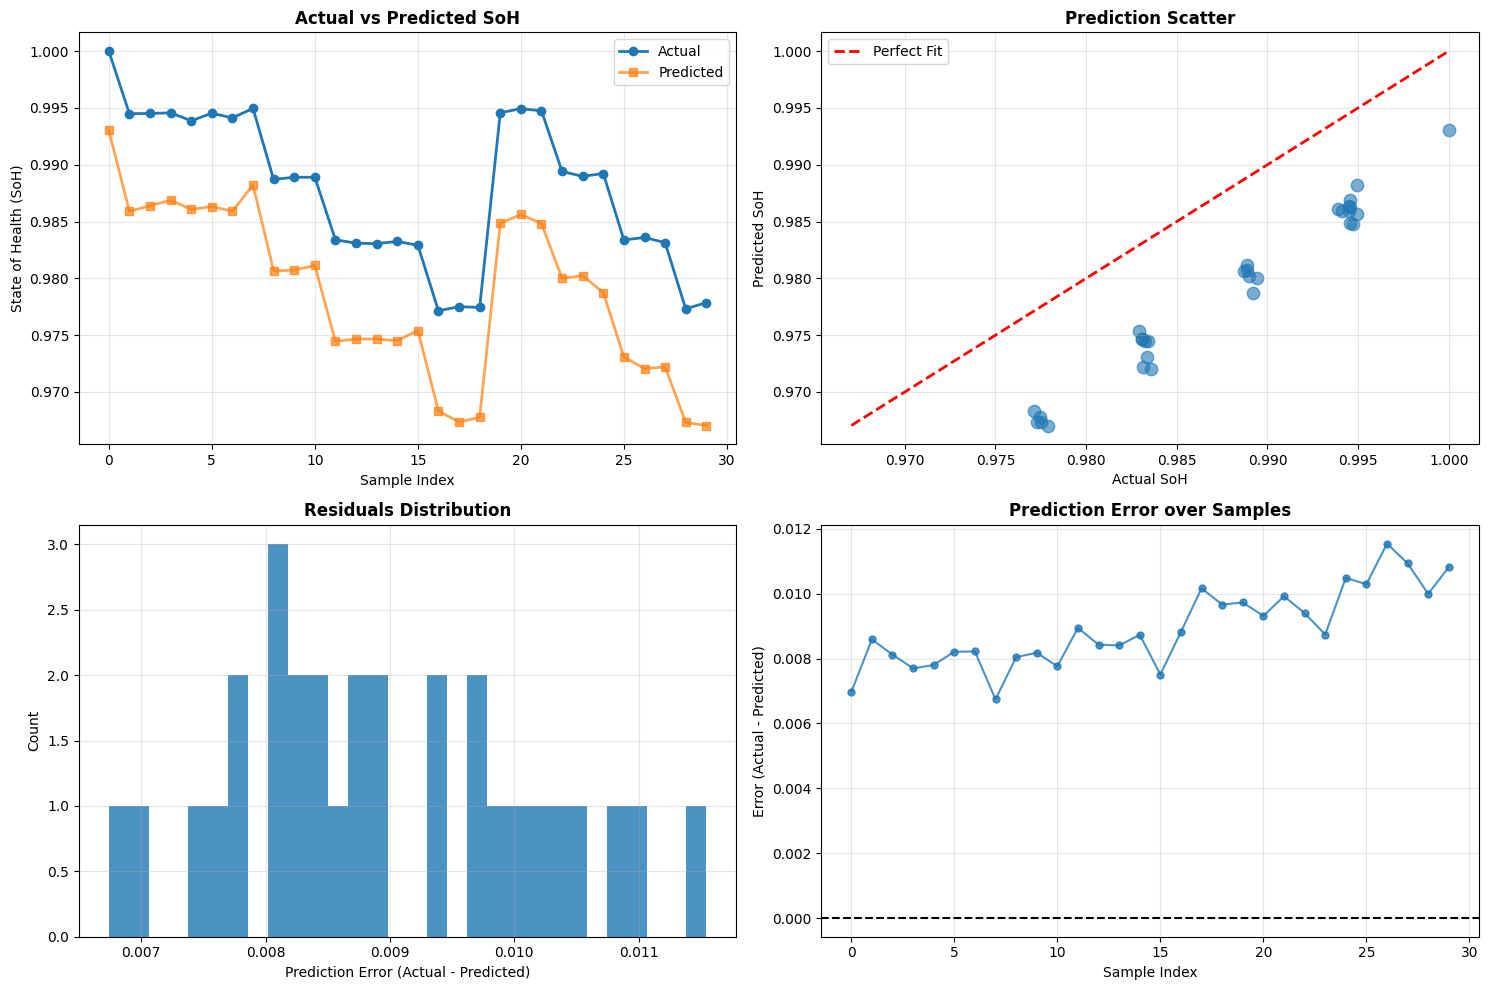


Batch prediction metrics:
MAE: 0.003689
RMSE: 0.004433


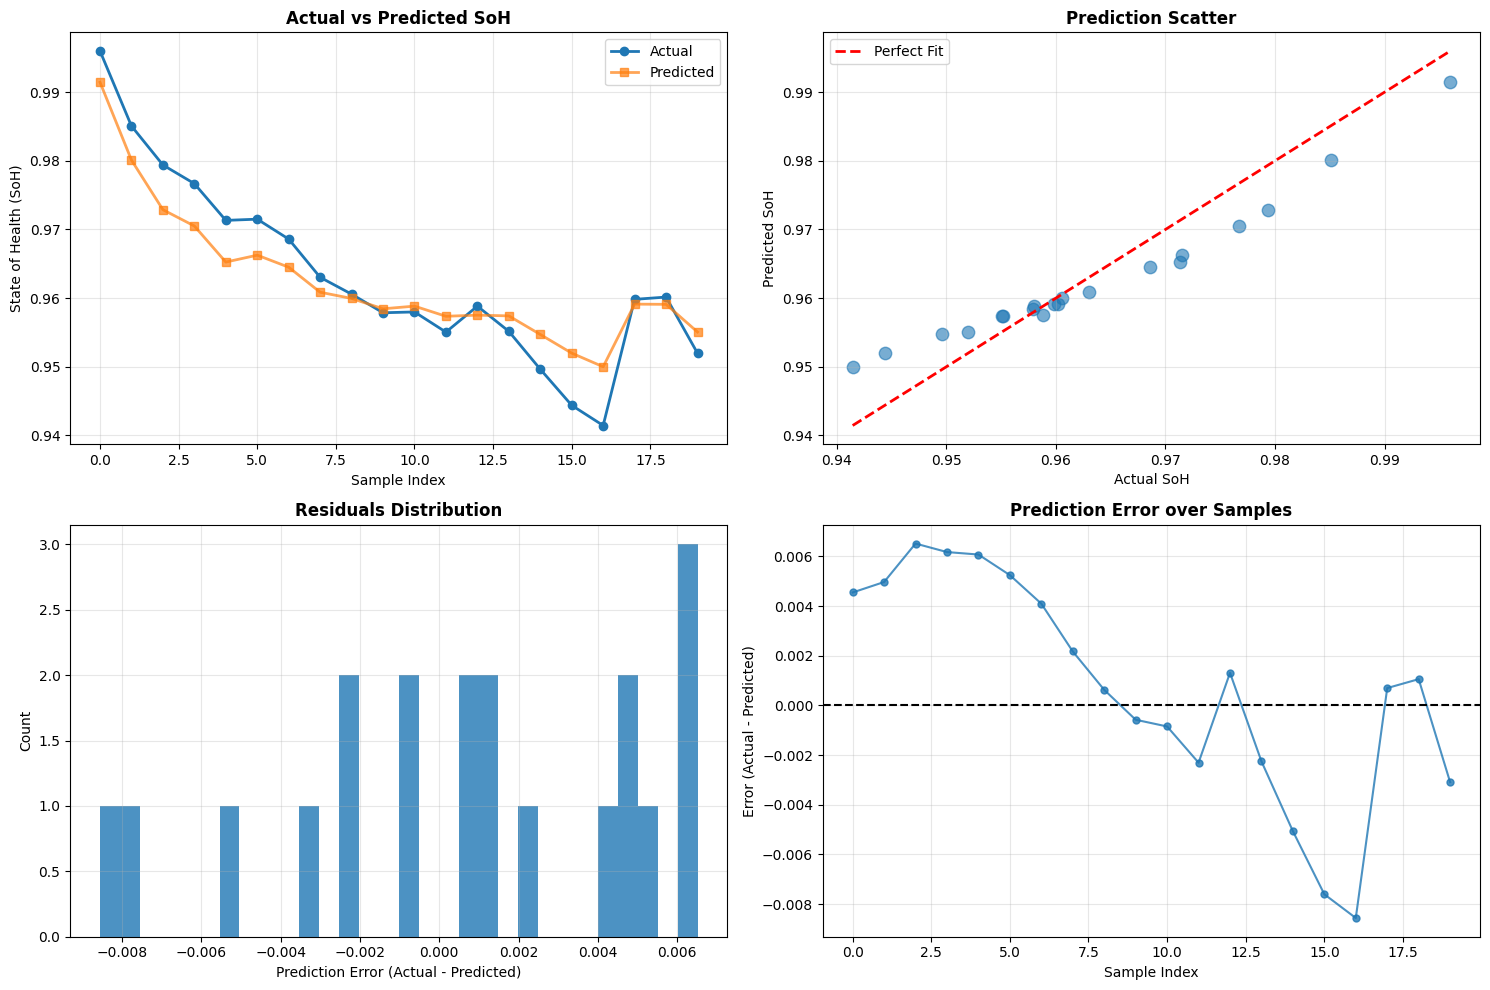


Running iterative (feedback) prediction...
Iter 1/20: True SoH=0.9960, Pred SoH=0.9891
Iter 11/20: True SoH=0.9580, Pred SoH=0.9577
Iter 20/20: True SoH=0.9520, Pred SoH=0.9541

Iterative prediction summary -> MAE: 0.004203, RMSE: 0.005034, R2: 0.8565


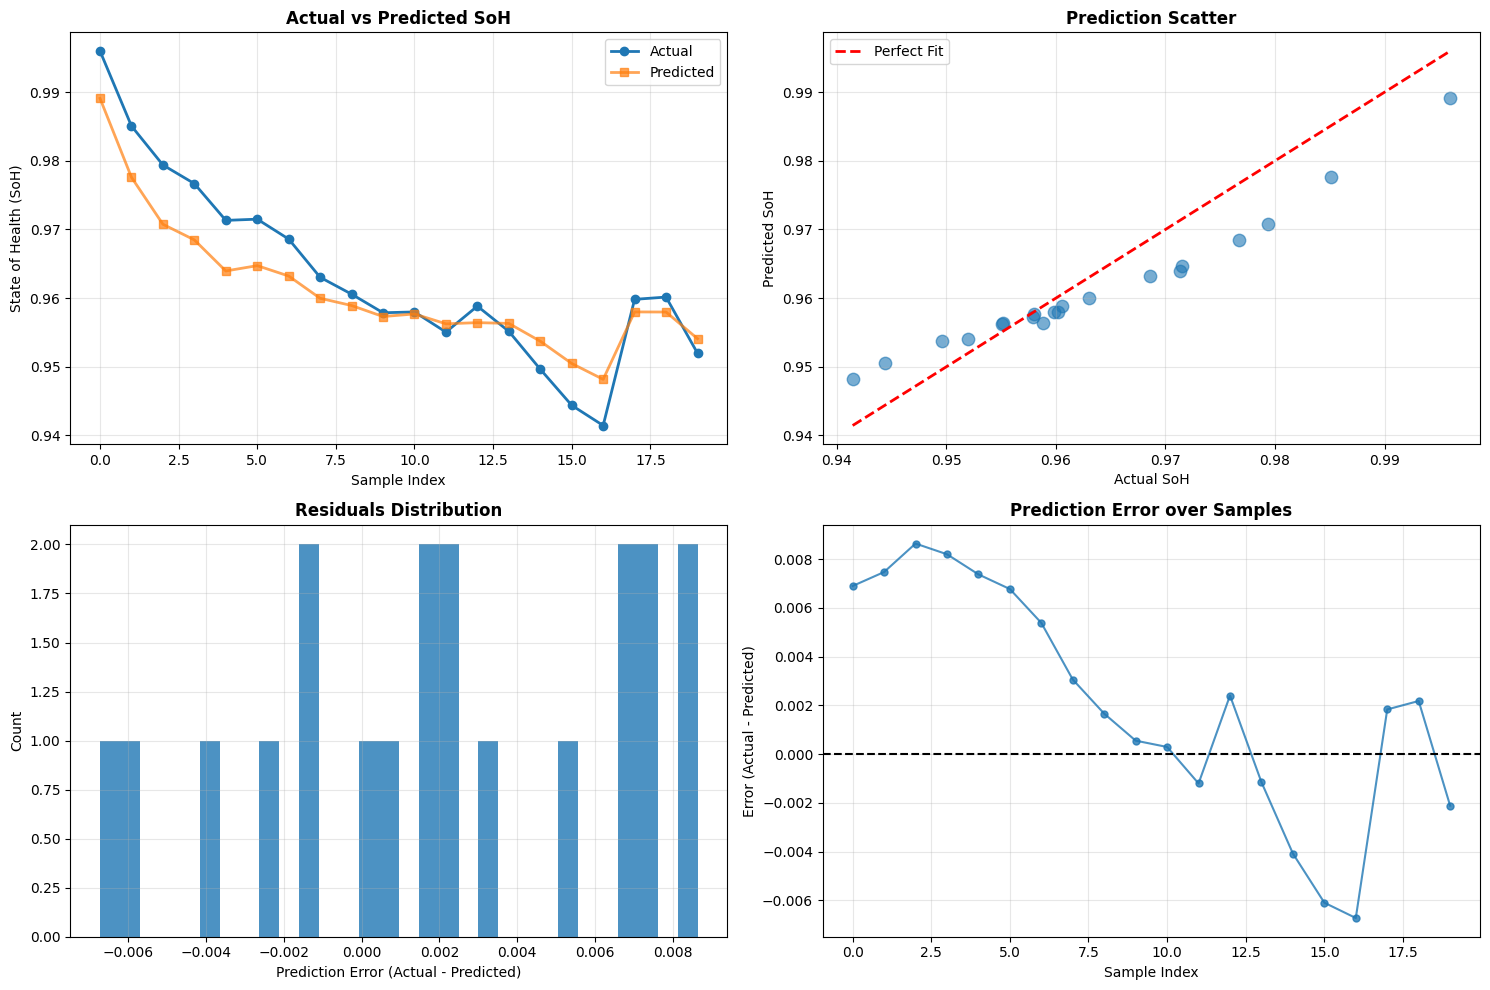


All done.


In [66]:

def main(run_training=True):
    # 1. Load training data
    try:
        train_df = load_all_training_data()
    except ValueError as e:
        print("Training data load failed:", e)
        return

    # 2. Engineer features
    train_df = engineer_cross_battery_features(train_df)

    # 3. Load test data with partial observation
    test_obs_df, test_pred_df = load_test_data(observe_cycles=Config.TEST_OBSERVE_CYCLES)

    if test_obs_df is not None:
        test_obs_df = engineer_cross_battery_features(test_obs_df)
    if test_pred_df is not None:
        test_pred_df = engineer_cross_battery_features(test_pred_df)

    # 4. Adaptive feature selection (you can override or pass precomputed list)
    selected_features = select_features_adaptive(train_df, target_col='SoH')
    print(f"Selected features ({len(selected_features)}): {selected_features}")

    # 5. Prepare data dictionaries with scalers
    data_dicts = prepare_data_for_training(train_df,
                                           test_df_observed=test_obs_df,
                                           test_df_predict=test_pred_df,
                                           selected_features=selected_features,
                                           target_col='SoH')

    # attach scalers to test sets for convenience
    scalers = data_dicts['scalers']
    scaler_X, scaler_y = scalers['X'], scalers['y']

    # 6. Train model (optional)
    if run_training:
        model, history = train_multi_battery_model(data_dicts, config=Config)
        plot_training_history(history)
        save_model_and_scalers(model, scaler_X, scaler_y, path_prefix='multi_batt')
    else:
        # Attempt to load saved model if exists
        try:
            model, scaler_X, scaler_y = load_model_and_scalers('multi_batt_model.h5', 'multi_batt_scalers.pkl')
        except Exception as e:
            print("Could not load existing model/scalers. Set run_training=True to train a new one.")
            return

    # 7. Evaluate on observed test portion if available
    if 'observed' in data_dicts['test']:
        obs = data_dicts['test']['observed']
        obs['scaler_y'] = scaler_y  # attach for evaluation
        obs['y_original'] = obs.get('y_original', obs['y'])  # ensure original available
        eval_obs = evaluate_model_comprehensive(model, {'X': obs['X'], 'y': obs['y'], 'y_original': obs['y_original'], 'scaler_y': scaler_y}, phase_name="Observed")
        plot_prediction_results(eval_obs)

    # 8. Direct prediction on the future portion (batch) if available
    if 'predict' in data_dicts['test']:
        pred = data_dicts['test']['predict']
        y_pred_batch = direct_predict(model, pred['X'], scaler_y)
        batch_results = {
            'y_true': pred['y_original'],
            'y_pred': y_pred_batch
        }
        # compute metrics quickly
        print("\nBatch prediction metrics:")
        print(f"MAE: {mean_absolute_error(batch_results['y_true'], batch_results['y_pred']):.6f}")
        print(f"RMSE: {np.sqrt(mean_squared_error(batch_results['y_true'], batch_results['y_pred'])):.6f}")
        plot_prediction_results(batch_results, title="Batch Prediction Results")

        # 9. Iterative (feedback) prediction — uses raw test dataframes and selected_features
        if test_obs_df is not None and test_pred_df is not None:
            print("\nRunning iterative (feedback) prediction...")
            iter_results = iterative_predict_with_feedback(model, test_obs_df, test_pred_df,
                                                          selected_features, scaler_X, scaler_y,
                                                          config=Config, verbose=True)
            plot_prediction_results({'y_true': iter_results['y_true'], 'y_pred': iter_results['y_pred']},
                                    title="Iterative Prediction (Feedback) Results")

    print("\nAll done.")


# Only run main when this file is executed, not when imported
if __name__ == "__main__":
    # Set run_training=True to train; False to load model from disk (if exists)
    main(run_training=False)
